In [1]:
import sys
sys.path.append(r'/home1/roeyshafran/BrainCap/Mind-Cap/code/Mind_Vis_utils/')

from fmri_caption import GPTCaptionModel, create_fmri_encoder_from_pretrained,top_k_top_p_filtering, set_parameter_requires_grad, define_GPTCaption_model
from utils import calculate_accuracy_on_test, calculate_semantic_similarity, state_dict_MLP_to_MLP_dropout, get_k_best_torch, print_batch
from dataset import BOLD5000_dataset, identity
from dataset import create_BOLD5000_dataset
from torch.utils.data import DataLoader, Subset
import torch
import torch.optim as optim
import torch.nn.functional as F
from sentence_transformers import SentenceTransformer, util
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import heapq
from datetime import datetime
#import optuna
%matplotlib inline

#### Setup

In [2]:
# Parameters
BATCH_SIZE = 8
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
LEARNING_RATE = 1.25e-5
NUM_EPOCHS = 16
TRIAL_NUM_TRAIN_EXAMPLES = BATCH_SIZE*30
TRIAL_NUM_VAL_EXAMPLES = BATCH_SIZE*10
WARMUP_STEPS = 2000

cuda:0


In [3]:
# Pretrained files
path_fmri_encoder = r"/databases/roeyshafran/BrainCap/pretrains/pretrain_metafile.pth"
#path_BOLD_dataset = r"/databases/roeyshafran/BrainCap/data/BOLD5000/CSI1_dataset.pth"
path_BOLD_dataset = r"/databases/roeyshafran/BrainCap/data/CSI1_no_duplicates.pth"

# create BOLD5000 dataset
BOLD_dataset = torch.load(path_BOLD_dataset)
bold_train, bold_test = BOLD_dataset['train'], BOLD_dataset['test']
#num_voxels = bold_test.num_voxels
num_voxels = 1696


In [4]:
print(f"Original train len: {len(bold_train)}, Original test len {len(bold_test)}")

Original train len: 2154, Original test len 52


In [5]:
train_idx, val_idx = train_test_split(list(range(len(bold_train))),test_size=0.1)
bold_val = Subset(bold_train, val_idx)
bold_train = Subset(bold_train, train_idx)

train_dl = DataLoader(bold_train, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(bold_val, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(bold_test, batch_size=BATCH_SIZE, shuffle=True)

print(f"Train len: {len(bold_train)}, val len: {len(bold_val)}")


Train len: 1938, val len: 216


#### Function Delerations

#### Optuna Tuning

In [ ]:
sampler = optuna.samplers.TPESampler()
study = optuna.create_study(study_name="BOLD5000-caption", direction="maximize", sampler=sampler)
study.optimie(objective, n_trials=100, timeout=1000)

pruned_trails = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]

print("Study statistics: ")
print(" Number of finished trials: ", len(study.trials))
print(" Number of pruned trials: ", len(pruned_trials))
print(" Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print(" Value: ", trial.value)

print(" Params: ")
for key, value in trial.params.items():
    print(" {}: {}".format(key, value))

In [ ]:
optuna.visualization.plot_param_importance(study)

In [ ]:
optuna.visualization.plot_contour(study, params=['lr', 'batch_size'])

#### Training Loop

In [6]:
# Get encoder-decoder
encoder = create_fmri_encoder_from_pretrained(path_fmri_encoder, num_voxels, feature_extraction=True)
encoder = encoder.to(device)
#projection_sizes = [encoder.embed_dim, 2*encoder.embed_dim, 2*encoder.embed_dim, 2*encoder.embed_dim, 2*encoder.embed_dim, 2*encoder.embed_dim, 
#4*encoder.embed_dim, 4*encoder.embed_dim, 2*encoder.embed_dim]
projection_sizes = [encoder.embed_dim,4*encoder.embed_dim, 4*encoder.embed_dim,4*encoder.embed_dim, 2*encoder.embed_dim]
decoder = define_GPTCaption_model(encoder, projection_sizes=projection_sizes, use_dropout=True)

Position interpolate from 262 to 106
missing keys: ['mask_token']
unexpected keys: ['decoder_pos_embed', 'decoder_embed.weight', 'decoder_embed.bias', 'decoder_blocks.0.norm1.weight', 'decoder_blocks.0.norm1.bias', 'decoder_blocks.0.attn.qkv.weight', 'decoder_blocks.0.attn.qkv.bias', 'decoder_blocks.0.attn.proj.weight', 'decoder_blocks.0.attn.proj.bias', 'decoder_blocks.0.norm2.weight', 'decoder_blocks.0.norm2.bias', 'decoder_blocks.0.mlp.fc1.weight', 'decoder_blocks.0.mlp.fc1.bias', 'decoder_blocks.0.mlp.fc2.weight', 'decoder_blocks.0.mlp.fc2.bias', 'decoder_blocks.1.norm1.weight', 'decoder_blocks.1.norm1.bias', 'decoder_blocks.1.attn.qkv.weight', 'decoder_blocks.1.attn.qkv.bias', 'decoder_blocks.1.attn.proj.weight', 'decoder_blocks.1.attn.proj.bias', 'decoder_blocks.1.norm2.weight', 'decoder_blocks.1.norm2.bias', 'decoder_blocks.1.mlp.fc1.weight', 'decoder_blocks.1.mlp.fc1.bias', 'decoder_blocks.1.mlp.fc2.weight', 'decoder_blocks.1.mlp.fc2.bias', 'decoder_blocks.2.norm1.weight', 'dec

In [7]:
#decoder = decoder.to(device)
optimizer = optim.AdamW(decoder.parameters(), lr=LEARNING_RATE, weight_decay=0.2)
#scheduler = get_linear_schedule_with_warmup(
#    optimizer, num_warmup_steps=WARMUP_STEPS, num_training_steps=NUM_EPOCHS*len(train_dl)
#    )

scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [1], gamma=0.5, verbose=True)
use_amp = False
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

Adjusting learning rate of group 0 to 1.2500e-05.


In [8]:
# Train
decoder.train()
encoder.eval()
decoder.to(device)
print("\n\n")
running_loss = []
running_semantic_accuracy = []
val_accuracy = []
lr_monitor = []
for epoch in range(NUM_EPOCHS):
    print(f"** Starting epoch {epoch} **")
    decoder.train()
    with tqdm(train_dl, unit='batch') as tepoch:
      semantic_accuracy = 0
      for batch_idx, batch in enumerate(tepoch):
          decoder.train()
          tepoch.set_description(f"Epoch: {epoch}")

          #batch_fmri = batch['fmri'].to(device)
          batch_fmri = batch['fmri']
          batch_fmri = batch_fmri.to(device)
          batch_caption = batch['caption']

          with torch.cuda.amp.autocast(enabled=use_amp):
            #print(f">>>> encoding fmri scans ", end="")
            fmri_prefix = encoder.forward(batch_fmri)
            #print(f"-> tokenizing captions ", end="")
            tokens, attention_mask = decoder.tokenizer(batch_caption, return_tensors="pt", padding=True).values()
            tokens, attention_mask, fmri_prefix = tokens.to(device), attention_mask.to(device), fmri_prefix.to(device)
            #print(f"-> decoding ")
            outputs = decoder.forward(tokens, fmri_prefix, attention_mask)
            logits = outputs.logits[:, decoder.prefix_length-1:-1]
            loss = F.cross_entropy(logits.reshape(-1, logits.shape[-1]), tokens.flatten(), ignore_index=decoder.tokenizer.pad_token_id)

          decoder.zero_grad(set_to_none=True)
          optimizer.zero_grad(set_to_none=True)
          scaler.scale(loss).backward()
          scaler.step(optimizer)
          scaler.update()
          
          #print(f">>>> batch {batch_idx} finished", end="\r")

          # Eval semantic accuracy
          if batch_idx % 10 == 0:
            decoder.eval()
            with torch.no_grad():
              generated_caption = decoder.generate_caption(fmri_prefix, device)
              semantic_accuracy = torch.mean(calculate_semantic_similarity(generated_caption, batch_caption, device)).item()
              running_semantic_accuracy.append(semantic_accuracy)
              running_loss.append(loss.item())
              lr_monitor.append(scheduler.get_last_lr())
          
          tepoch.set_postfix(loss=loss.item(), train_accuracy=semantic_accuracy)

          # Free GPU memory
          del batch_fmri, batch_caption, tokens, attention_mask, logits, outputs, loss
          torch.cuda.empty_cache()
    decoder.eval()
    val_accuracy.append(calculate_accuracy_on_test(encoder, decoder, val_dl, device, return_best_batch=False))
    print(f"---- epoch {epoch} loss: {np.mean(running_loss[int(np.floor((epoch*len(train_dl))/10 + 1)):-1]):.4}, train accuracy: {np.mean(running_semantic_accuracy[int(np.floor((epoch*len(train_dl))/10 + 1)):-1]):.4}, validation accuracy (running, % above thresh): {val_accuracy[-1]} ---- ")
    scheduler.step()





** Starting epoch 0 **


Epoch: 0: 100%|██████████| 243/243 [01:25<00:00,  2.85batch/s, loss=4.16, train_accuracy=0.0963]


---- epoch 0 loss: 3.616, train accuracy: 0.07682, validation accuracy (running, % above thresh): (0.08603957254025671, 0.0) ---- 
Adjusting learning rate of group 0 to 6.2500e-06.
** Starting epoch 1 **


Epoch: 1: 100%|██████████| 243/243 [01:18<00:00,  3.11batch/s, loss=3.71, train_accuracy=0.109] 


---- epoch 1 loss: 3.691, train accuracy: 0.08094, validation accuracy (running, % above thresh): (0.10064912063104135, 0.004629629629629629) ---- 
Adjusting learning rate of group 0 to 6.2500e-06.
** Starting epoch 2 **


Epoch: 2: 100%|██████████| 243/243 [01:21<00:00,  2.99batch/s, loss=3.18, train_accuracy=0.106] 


---- epoch 2 loss: 3.461, train accuracy: 0.09042, validation accuracy (running, % above thresh): (0.09252708350066785, 0.004629629629629629) ---- 
Adjusting learning rate of group 0 to 6.2500e-06.
** Starting epoch 3 **


Epoch: 3: 100%|██████████| 243/243 [01:14<00:00,  3.26batch/s, loss=3.11, train_accuracy=0.14]  


---- epoch 3 loss: 3.648, train accuracy: 0.0947, validation accuracy (running, % above thresh): (0.10687647911685484, 0.004629629629629629) ---- 
Adjusting learning rate of group 0 to 6.2500e-06.
** Starting epoch 4 **


Epoch: 4: 100%|██████████| 243/243 [01:18<00:00,  3.08batch/s, loss=3.61, train_accuracy=0.083]  


---- epoch 4 loss: 3.618, train accuracy: 0.09917, validation accuracy (running, % above thresh): (0.09287556660947976, 0.0) ---- 
Adjusting learning rate of group 0 to 6.2500e-06.
** Starting epoch 5 **


Epoch: 5: 100%|██████████| 243/243 [01:14<00:00,  3.26batch/s, loss=3.04, train_accuracy=0.121] 


---- epoch 5 loss: 3.563, train accuracy: 0.09804, validation accuracy (running, % above thresh): (0.09744298030380849, 0.0) ---- 
Adjusting learning rate of group 0 to 6.2500e-06.
** Starting epoch 6 **


Epoch: 6: 100%|██████████| 243/243 [01:18<00:00,  3.11batch/s, loss=4.16, train_accuracy=0.147] 


---- epoch 6 loss: 3.473, train accuracy: 0.1112, validation accuracy (running, % above thresh): (0.09927248561547862, 0.0) ---- 
Adjusting learning rate of group 0 to 6.2500e-06.
** Starting epoch 7 **


Epoch: 7: 100%|██████████| 243/243 [01:17<00:00,  3.14batch/s, loss=3.07, train_accuracy=0.0161]


KeyboardInterrupt: 

#### Save Model

In [9]:
decoder.eval()
acc, above_threshold = calculate_accuracy_on_test(encoder, decoder, test_dl, device, return_best_batch=False)
print(acc, above_threshold)

0.10588394850492477 0.0


In [ ]:
to_save = {
    'comment': "Small architecture on the CSI1_no_duplicates set. Transfer learning from no_dup_encoder_0.1555_0.01389_0.1748_22012023_09-45-51.pth. 16+16+16 epochs with lr=1.25e-5 Dropout=0.3. with decoder.eval(). started overfitting again. Last checkpoint ended with higher accuracy on test.",
    'hyperparameters': {'batch_size': BATCH_SIZE},
    'decoder_projection': {'sizes': decoder.projection_sizes, 'sd': decoder.embedding_space_projection.state_dict()},
    'optimizer': {'type': type(optimizer), 'sd': optimizer.state_dict()['param_groups']},
    'scheduler': {'type': type(scheduler), 'sd': scheduler.state_dict()},
    'training_data': {
        "running_loss": running_loss,
        'running_semantic_accuracy': running_semantic_accuracy,
        'val_accuracy': val_accuracy,
        'lr_monitor': lr_monitor
    }
}

now = datetime.now()
dt_string = now.strftime("%d%m%Y_%H-%M-%S")
torch.save(to_save, f'/databases/roeyshafran/BrainCap/Checkpoints/no_dup_encoder_{val_accuracy[-1][0]:.4}_{val_accuracy[-1][1]:.4}_{acc:.4}_{dt_string}.pth')

#### Load Model

In [11]:
model_dict = torch.load(r'/databases/roeyshafran/BrainCap/Checkpoints/middle_checkpoint_dropout_starts_from_hereno_dup_encoder_0.189_0.05556_0.18_22012023_12-20-13.pth')
#model_dict = torch.load(r'/databases/roeyshafran/BrainCap/Checkpoints/encoder_0.1626_0.02778_20012023_11-54-46.pth')
#loaded_decoder.load_state_dict(model_dict['decoder'])

In [12]:
print(model_dict.keys())
print(model_dict['comment'])
#decoder.embedding_space_projection.load_state_dict(model_dict['decoder_projection']['sd'])
running_loss = model_dict['training_data']['running_loss']
running_semantic_accuracy = model_dict['training_data']['running_semantic_accuracy']
val_accuracy = model_dict['training_data']['val_accuracy']
lr_monitor = model_dict['training_data']['lr_monitor']
#scheduler.load_state_dict(model_dict['scheduler']['sd'])
#optimizer.load_state_dict(model_dict['optimizer'])
new_sd = state_dict_MLP_to_MLP_dropout(decoder.embedding_space_projection.state_dict(), model_dict['decoder_projection']['sd'])
print(decoder.embedding_space_projection.load_state_dict(new_sd))
set_parameter_requires_grad(decoder.embedding_space_projection, feature_extraction=False)
del model_dict
torch.cuda.empty_cache()

dict_keys(['comment', 'hyperparameters', 'decoder_projection', 'optimizer', 'scheduler', 'training_data'])
Small architecture on the CSI1_no_duplicates set. Transfer learning from no_dup_encoder_0.1555_0.01389_0.1748_22012023_09-45-51.pth. Adding 8 epochs with last lr=1.25e-5 and weigth_decay=0.2
<All keys matched successfully>


In [ ]:
decoder.embedding_space_projection.model

#### Visualize Results

In [ ]:
scheduler.get_last_lr()

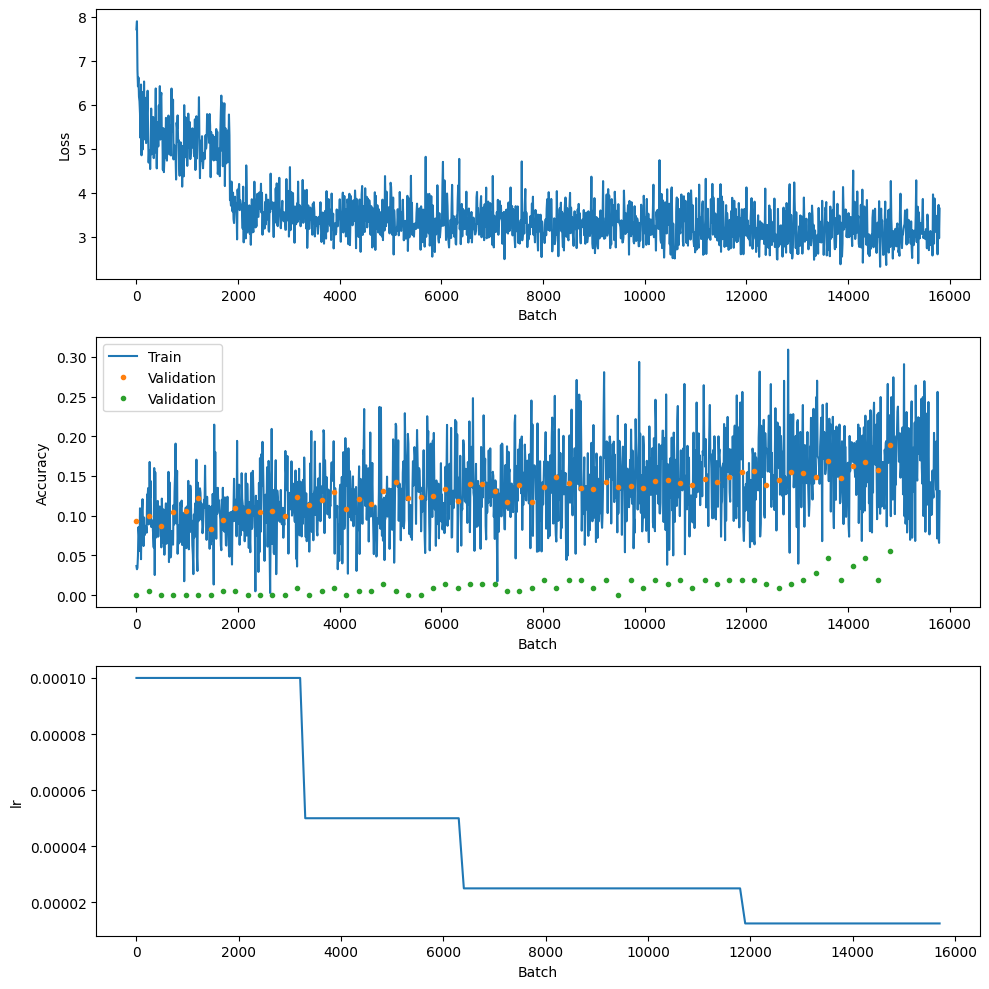

In [13]:
fig, axs = plt.subplots(3,1, figsize=(10,10))
axs = axs.flatten()
#batch_iterations = np.arange(0, len(train_dl)*NUM_EPOCHS+1, 10)
batch_iterations = np.arange(0, len(running_loss)*10, 10)
val_iterations = np.arange(0, len(val_accuracy)*len(train_dl), len(train_dl))
axs[0].plot(batch_iterations, running_loss)
axs[0].set_xlabel('Batch')
axs[0].set_ylabel('Loss')

axs[1].plot(batch_iterations, running_semantic_accuracy, label='Train')
#axs[1].plot(batch_iterations[0:-1:int(np.ceil(len(running_loss)/10))], val_accuracy, '.', label='Validation')
axs[1].plot(val_iterations, val_accuracy, '.', label='Validation')
axs[1].set_xlabel('Batch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

axs[2].plot(batch_iterations[:-1:10], np.array(lr_monitor).squeeze()[0:-1:10])
axs[2].set_xlabel('Batch')
axs[2].set_ylabel('lr')

#axs[3].plot(batch_iterations[:-1], val_accuracy)
#axs[3].set_xlabel('Batch')
#axs[3].set_ylabel('lr')

fig.tight_layout() 



In [14]:
decoder.to(device)
decoder.eval()
acc_test, above_thresh_test = calculate_accuracy_on_test(encoder, decoder, test_dl, device, return_best_batch=False)
# acc_val, above_thresh_val = calculate_accuracy_on_test(encoder, decoder, val_dl, device, return_best_batch=False)
# acc_train, above_thresh_train = calculate_accuracy_on_test(encoder, decoder, train_dl, device, return_best_batch=False)

# print(f"Train: {acc_train}, {above_thresh_train*100}%")
# print(f"Validaion: {acc_val}, {above_thresh_val*100}%")
print(f"Test: {acc_test}, {above_thresh_test*100}%")


Test: 0.1704392528959683, 3.571428571428571%


In [16]:
#acc, best_batch = calculate_accuracy_on_test(encoder, decoder, test_dl, device, return_best_batch=True)
# best_k_val = get_k_best_torch(encoder, decoder, val_dl, 2, device)
# best_k_train = get_k_best_torch(encoder, decoder, train_dl, 2, device)
best_k_test = get_k_best_torch(encoder, decoder, test_dl, 2, device)

In [17]:

# best_k_train['image'] = best_k_train['image'].cpu()
# best_k_train['fmri'] = best_k_train['fmri'].cpu()
# best_k_train['accuracy'] = best_k_train['accuracy'].cpu()
# best_k_train_records = [dict(zip(best_k_train,t)) for t in zip(*best_k_train.values())]

best_k_test['image'] = best_k_test['image'].cpu()
best_k_test['fmri'] = best_k_test['fmri'].cpu()
best_k_test['accuracy'] = best_k_test['accuracy'].cpu()
best_k_test_records = [dict(zip(best_k_test,t)) for t in zip(*best_k_test.values())]

# best_k_val['image'] = best_k_val['image'].cpu()
# best_k_val['fmri'] = best_k_val['fmri'].cpu()
# best_k_val['accuracy'] = best_k_val['accuracy'].cpu()
# best_k_val_records = [dict(zip(best_k_val,t)) for t in zip(*best_k_val.values())]


(0) Generated: <|endoftext|>A blue jet flying over earth at night in the sky.
   Real: A jet plane that is flying in the sky.  Accuracy: 0.6913734078407288
(1) Generated: <|endoftext|>A plastic cabinet with a small light tv set in it.
   Real: A table topped with cut in half sandwiches and salads.  Accuracy: 0.37276941537857056


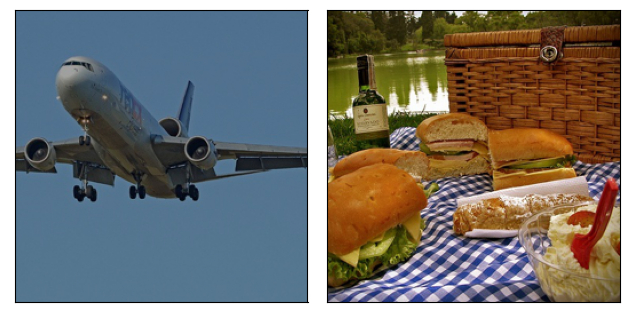

In [18]:
print_batch(best_k_test_records, fontsize=10, num_of_columns=2, caption_as_title=False)

In [ ]:
print_batch(best_k_train_records, fontsize=10, num_of_columns=5, caption_as_title=False)


In [ ]:
print_batch(best_k_val_records, fontsize=10, num_of_columns=5, caption_as_title=False)